# N-BEATS Time Series Forecasting: A Step-by-Step Walkthrough

Welcome! In this notebook, we'll walk through how to use the N-BEATS model from Econometron to forecast a macroeconomic time series (like interest rates). We'll go from data loading and visualization, through model setup and training, all the way to evaluation and insightful visualizations. Let's get started!

## 1. Import Libraries
First, let's import the necessary modules. We'll use Econometron's N-BEATS implementation and some standard plotting libraries.

In [52]:
import econometron.Models.n_beats as Nbeats


## 2. Load and Visualize Data
Let's load our interest rate data from `Z.mat`, scale it for better training, and plot it to get a feel for the series we're about to forecast.

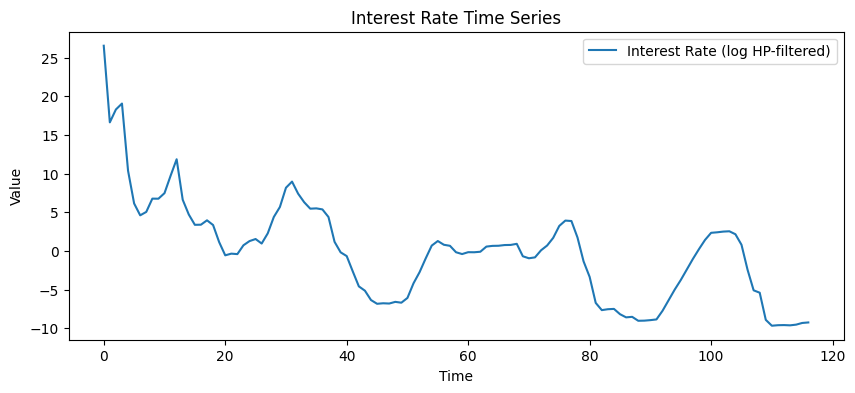

In [53]:
# Load the interest rate 
data = scipy.io.loadmat('../Z.mat')["Z"][0, :]*1000

# Plot the raw data
plt.figure(figsize=(10, 4))
plt.plot(data, label="Interest Rate (log HP-filtered)")
plt.title("Interest Rate Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

## 3. Configure the N-BEATS Model
Now, we'll set up the N-BEATS model. We'll define the stack configurations, which control how the model captures different patterns in the data (like trends, seasonality, and generic components).

In [54]:
backcast_length = 20   # Use 20 Q's of history
forecast_length = 5     # Predict next 5 Q's

# Create stack configurations
stack_configs = [
    {
        'n_blocks': 3,
        'basis_type': 'polynomial',
        'n_layers_per_block': 5,
        'hidden_size': 512,
        'degree': 2,
        'share_weights': True
    },
    {
        'n_blocks': 3,
        'basis_type': 'fourier',
        'n_layers_per_block': 5,
        'hidden_size': 512,
        'share_weights': True
    },
    {
        'n_blocks': 2,
        'basis_type': 'generic',
        'n_layers_per_block': 5,
        'hidden_size': 512,
        'share_weights': True
    }
]



In [55]:
# Initialize model
model = Nbeats.NeuralForecast(
    stack_configs=stack_configs,
    backcast_length=backcast_length,
    forecast_length=forecast_length
)

print(f"Model created with {sum(p.numel() for p in model.model.parameters()):,} parameters")

NeuralForecast initialized on cpu
Model parameters: 3,210,318
Model created with 3,210,318 parameters


## 5. Prepare and Split Data
Let's split our time series into training, validation, and test sets. This is crucial for evaluating how well our model generalizes to unseen data.

In [56]:
print("\n5. Processing and splitting data...")

train_data, val_data, test_data = model.process_data(
    data=data,
    train_ratio=0.8,
    val_ratio=0.15,
    normalize=False
)


5. Processing and splitting data...
Data processed - Train: 74, Val: 13, Test: 6


## 6. Train the Model
Now for the fun part: training! We'll fit the N-BEATS model to our training data, using early stopping and learning rate scheduling to get the best results.

In [57]:
# 6. Train the model
print("\n6. Training the model...")
history = model.fit(
    train_data=train_data,
    val_data=val_data,
    epochs=100,
    batch_size=32,
    learning_rate=1e-3,
    optimizer='adam',
    loss_function='mae',
    early_stopping=True,
    patience=15,
    scheduler='plateau',
    gradient_clip=1.0,
    verbose=True
)


6. Training the model...
Starting training...
Epoch 10/100 - Train Loss: 3.985974, Val Loss: 4.490149, LR: 1.00e-03, Time: 0.29s
Epoch 10/100 - Train Loss: 3.985974, Val Loss: 4.490149, LR: 1.00e-03, Time: 0.29s
Epoch 20/100 - Train Loss: 1.990738, Val Loss: 3.704771, LR: 1.00e-03, Time: 0.30s
Epoch 20/100 - Train Loss: 1.990738, Val Loss: 3.704771, LR: 1.00e-03, Time: 0.30s
Epoch 30/100 - Train Loss: 0.776270, Val Loss: 4.452342, LR: 5.00e-04, Time: 0.25s
Epoch 30/100 - Train Loss: 0.776270, Val Loss: 4.452342, LR: 5.00e-04, Time: 0.25s
Early stopping at epoch 37
Training completed! Best validation loss: 2.959307
Early stopping at epoch 37
Training completed! Best validation loss: 2.959307


## 7. Plot Training History
Let's visualize how the training and validation losses evolved. This helps us spot overfitting or underfitting and see if our model is learning effectively.


7. Plotting training history...


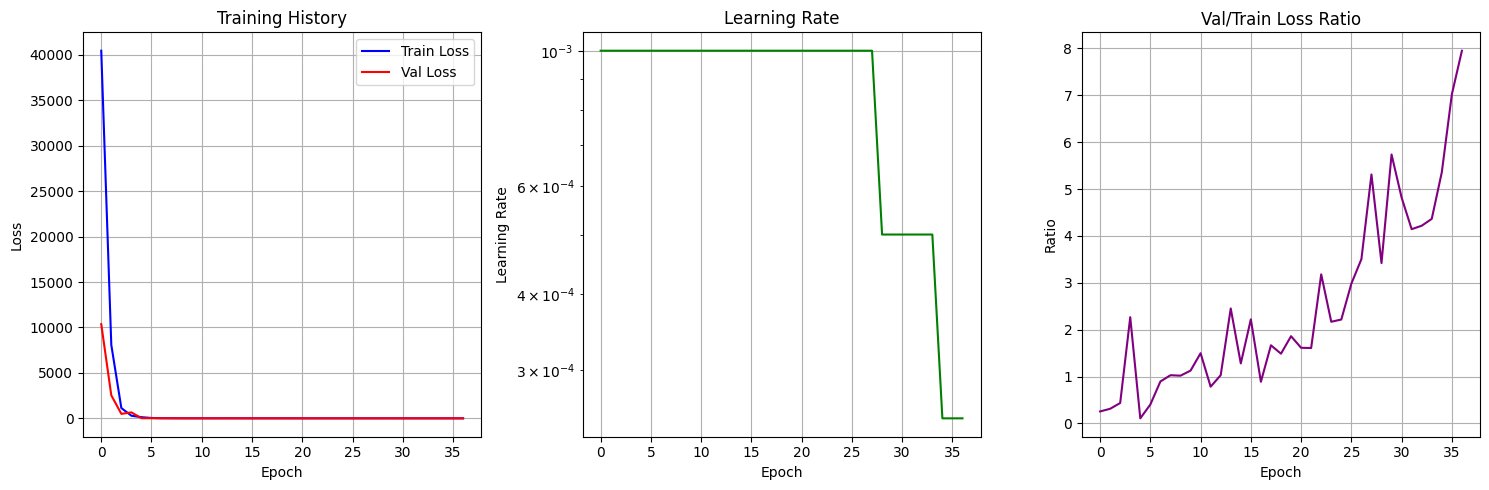

In [58]:
# 7. Plot training history
print("\n7. Plotting training history...")
model.plot_training_history()

## 8. Evaluate Model Performance
How well did our model do? We'll check its performance on the test set using metrics like MAE, MSE, RMSE, and MAPE.

In [59]:
# 8. Evaluate on test data
print("\n8. Evaluating on test data...")

test_metrics = model.evaluate(
    test_data=test_data,
    metrics=['mae', 'mse', 'rmse', 'mape']
)


8. Evaluating on test data...
Evaluation Results:
------------------------------
MAE: 3.729940
MSE: 20.328505
RMSE: 4.508714
MAPE: 43.788230


## 9. Generate and Display Forecasts
Let's use our trained model to forecast the next few periods. We'll print out the predicted values so you can see the results up close.

In [60]:
# 9. Generate forecasts
print("\n9. Generating forecasts...")

# Use the last part of the data for forecasting
recent_data = data  # Last 
input_sequence = recent_data[-backcast_length:]  # Last 30 days as input

# Generate forecast with components
forecast, components = model.forecast(
    input_sequence=input_sequence,
    return_components=True
)

print(f"Forecast for next {forecast_length} Quarter:")
for i, pred in enumerate(forecast.flatten()):
    print(f"Quarters {i+1}: {pred:.2f}")



9. Generating forecasts...
Forecast for next 5 Quarter:
Quarters 1: -9.44
Quarters 2: -9.28
Quarters 3: -7.79
Quarters 4: -5.73
Quarters 5: -4.28

Forecast for next 5 Quarter:
Quarters 1: -9.44
Quarters 2: -9.28
Quarters 3: -7.79
Quarters 4: -5.73
Quarters 5: -4.28


## 10. Visualize Forecast and Components
Here's where it gets really interesting! We'll plot the historical data, our forecast, and break down the forecast into its component contributions. This gives us interpretability and insight into what the model has learned.


10. Plotting forecast results...


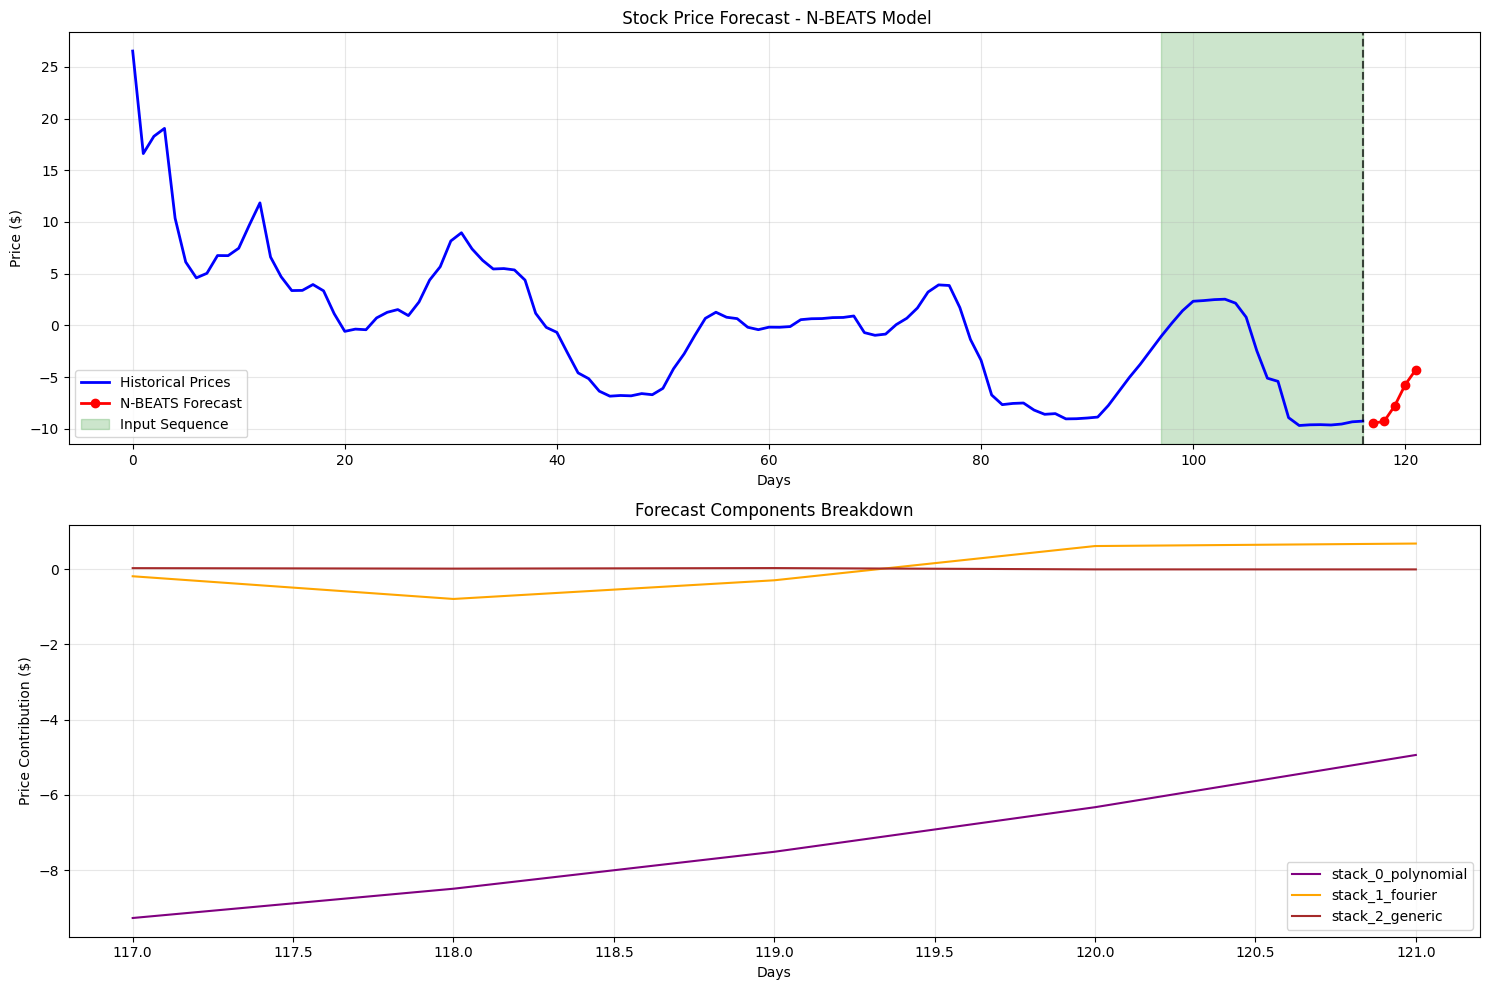

In [61]:
# 10. Plot comprehensive forecast
print("\n10. Plotting forecast results...")

# Create a more detailed forecast plot
plt.figure(figsize=(15, 10))

# Historical data (last 60 days)
hist_data = data
hist_time = np.arange(len(hist_data))

# Forecast data
forecast_flat = forecast.flatten()
forecast_time = np.arange(len(hist_data), len(hist_data) + len(forecast_flat))

# Main plot
plt.subplot(2, 1, 1)
plt.plot(hist_time, hist_data, label='Historical Prices', color='blue', linewidth=2)
plt.plot(forecast_time, forecast_flat, label='N-BEATS Forecast', 
            color='red', linewidth=2, marker='o')

# Add input sequence highlight
input_start = len(hist_data) - backcast_length
plt.axvspan(input_start, len(hist_data)-1, alpha=0.2, color='green', 
            label='Input Sequence')
plt.axvline(x=len(hist_data)-1, color='black', linestyle='--', alpha=0.7)

plt.title(f' Stock Price Forecast - N-BEATS Model')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Component breakdown
plt.subplot(2, 1, 2)
colors = ['purple', 'orange', 'brown', 'pink', 'gray']
for i, (name, component) in enumerate(components.items()):
    plt.plot(forecast_time, component.flatten(), 
            label=f'{name}', color=colors[i % len(colors)], linewidth=1.5)

plt.title('Forecast Components Breakdown')
plt.xlabel('Days')
plt.ylabel('Price Contribution ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## 11. Model Summary
Finally, let's display a summary of our trained N-BEATS model, including key statistics and configuration details. Great job making it to the end!

In [62]:
# 11. Model summary
print("\n11. Model Summary:")
print("=" * 40)
summary = model.get_model_summary()
for key, value in summary.items():
    if key != 'model_info':
        print(f"{key}: {value}")
        


11. Model Summary:
total_parameters: 3210318
trainable_parameters: 3210318
device: cpu
is_fitted: True
backcast_length: 20
forecast_length: 5
